In [ ]:
!pip install swig
!pip install "gymnasium[box2d]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 63.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Episode   1 | reward   -34.4 | steps   1000/100000 | buffer   1000 | last steer +0.994 | last gas 0.816 | last brake 0.684
Episode   2 | reward   -32.7 | steps   2000/100000 | buffer   2000 | last steer +0.085 | last gas 0.293 | last brake 0.852
Episode   3 | reward   -29.8 | steps   3000/100000 | buffer   3000 | last steer -0.039 | last gas 0.946 | last brake 0.030
Episode   4 | reward   -36.7 | steps   4000/100000 | buffer   4000 | last steer +0.138 | last gas 0.873 | last brake 0.639
Episode   5 | reward   -35.6 | steps   5000/100000 | buffer   5000 | last steer -0.700 | last gas 0.399 | last brake 0.986
Episode   6 | reward   -36.7 | steps   6000/100000 | buffer   6000 | last steer -0.179 | last gas 0.254 | last brake 0.114
Episode   7 | reward   -45.4 | steps   7000/100000 | buffer   7000 | last steer -0.881 | last gas 0.998 | last brake 0.407
Episode   8 | reward   -39.9 | steps   8000/100000 | buffer   8000 | last steer +0.916 | last gas 0.492 | last brake 0.508
Episode   9 | re

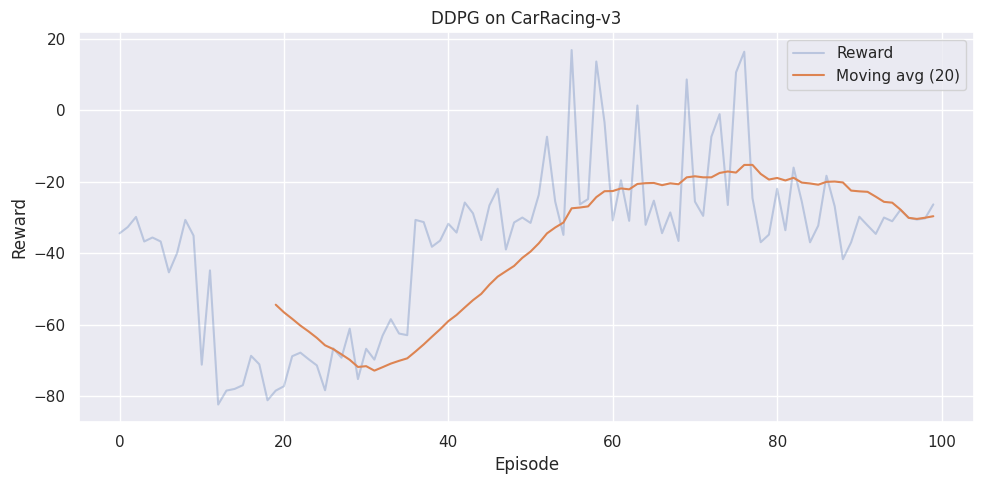

GIF saved


In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import random
import copy
from collections import deque
import os
import time
import matplotlib.pyplot as plt
from PIL import Image

import seaborn as sns
sns.set_theme()

from gymnasium.wrappers import (
    GrayscaleObservation,
    ResizeObservation,
    FrameStackObservation,
)


# CONFIG

ENV_NAME = "CarRacing-v3"
SEED = 42

TOTAL_STEPS = 100_000
START_STEPS = 10_000
TRAIN_EVERY = 1
MAX_EPISODE_STEPS = 1000

BATCH_SIZE = 128
BUFFER_SIZE = 20_000

GAMMA = 0.99
TAU = 0.005

LR_ACTOR = 1e-3
LR_CRITIC = 1e-3

ACTIONS_DIM = 3

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SAVE_DIR = "/content/drive/MyDrive/car_racing_v3_ddpg"
os.makedirs(SAVE_DIR, exist_ok=True)


# SEED

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


# ENV

def make_env(render_mode=None):
    env = gym.make(ENV_NAME, render_mode=render_mode)
    env.reset(seed=SEED)
    env = GrayscaleObservation(env)
    env = ResizeObservation(env, (84, 84))
    env = FrameStackObservation(env, stack_size=4)
    return env


# NETWORKS

class Actor(nn.Module):
    def __init__(self, actions_dim, hidden_dim=512):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(4, 32, 8, 4), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2), nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1), nn.ReLU(),
            nn.Flatten()
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 4, 84, 84)
            n_flat = self.cnn(dummy).shape[1]

        self.backbone = nn.Sequential(
            nn.Linear(n_flat, hidden_dim),
            nn.ReLU(),
        )

        self.means_head = nn.Linear(hidden_dim, actions_dim)

        self.log_stds = nn.Parameter(torch.ones(actions_dim) * 0.5)

        # prior meanы bias (steering = 0, gas = 0.5, brake = 0.5)
        self.register_buffer(
            "means_bias",
            torch.tensor([0.0, 0.5, 0.5])
        )

    def forward(self, x):
        x = self.cnn(x)
        h = self.backbone(x)

        means = self.means_head(h) + self.means_bias

        log_stds = torch.clamp(self.log_stds, -5.0, 2.0)
        stds = torch.exp(log_stds)

        return means, stds


class Critic(nn.Module):
    def __init__(self, actions_dim, hidden_dim=512):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(4, 32, 8, 4), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2), nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1), nn.ReLU(),
            nn.Flatten()
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 4, 84, 84)
            n_flat = self.cnn(dummy).shape[1]

        self.q_head = nn.Sequential(
            nn.Linear(n_flat + actions_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x, a):
        x = self.cnn(x)
        x = torch.cat([x, a], dim=1)
        q = self.q_head(x)
        return q


# REPLAY BUFFER

class ReplayBuffer:
    def __init__(self, size):
        self.buffer = deque(maxlen=size)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.array, zip(*batch))
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)


# OU NOISE

class OUNoise:
    def __init__(self, size, mu=np.array([0.0, 0.5, 0.5]),
                 theta=0.15, sigma=0.5, sigma_min=0.05, decay=0.99995):  # !!!
        self.size = size
        self.mu = mu
        self.theta = theta

        self.sigma = sigma
        self.sigma_min = sigma_min
        self.decay = decay

        self.reset()

    def reset(self):
        self.state = self.mu.copy()

    def sample(self):
        dx = self.theta * (self.mu - self.state)
        dx += self.sigma * np.random.randn(self.size)
        self.state += dx
        return self.state

    def step_decay(self):
        self.sigma = max(self.sigma_min, self.sigma * self.decay)


# ACTIONS

def select_action(actor, state):
    with torch.no_grad():
        state = (torch.tensor(state, dtype=torch.float32, device=DEVICE)
            .unsqueeze(0) / 255.0
        )

        mean, std = actor(state)
        action = Normal(mean, std).rsample()

        action[:, 0] = torch.tanh(action[:, 0])
        action[:, 1] = torch.sigmoid(action[:, 1])
        action[:, 2] = torch.sigmoid(action[:, 2])

        return action.squeeze(0).cpu().numpy()


# TRAIN STEP

def train_step():
    states, actions, rewards, next_states, dones = buffer.sample(BATCH_SIZE)

    states = torch.tensor(states, dtype=torch.float32, device=DEVICE) / 255.0
    next_states = torch.tensor(next_states, dtype=torch.float32, device=DEVICE) / 255.0
    actions = torch.tensor(actions, dtype=torch.float32, device=DEVICE)
    rewards = torch.tensor(rewards, dtype=torch.float32, device=DEVICE).unsqueeze(1)
    dones = torch.tensor(dones, dtype=torch.float32, device=DEVICE).unsqueeze(1)

    # critic update

    with torch.no_grad():
        means, stds = actor_target(next_states)
        next_actions = Normal(means, stds).rsample()
        next_actions[:, 0] = torch.tanh(next_actions[:, 0])
        next_actions[:, 1] = torch.sigmoid(next_actions[:, 1])
        next_actions[:, 2] = torch.sigmoid(next_actions[:, 2])
        q_target = rewards + GAMMA * (1 - dones) * critic_target(next_states, next_actions)

    q_current = critic(states, actions)
    critic_loss = F.mse_loss(q_current, q_target)

    opt_critic.zero_grad()
    critic_loss.backward()
    opt_critic.step()

    # actor update

    means, stds = actor(states)
    new_actions = Normal(means, stds).rsample()
    new_actions[:, 0] = torch.tanh(new_actions[:, 0])
    new_actions[:, 1] = torch.sigmoid(new_actions[:, 1])
    new_actions[:, 2] = torch.sigmoid(new_actions[:, 2])

    actor_loss = -critic(states, new_actions).mean()

    opt_actor.zero_grad()
    actor_loss.backward()
    opt_actor.step()

    # soft updates

    for target_param, param in zip(actor_target.parameters(), actor.parameters()):
        target_param.data.mul_(1 - TAU).add_(TAU * param.data)

    for target_param, param in zip(critic_target.parameters(), critic.parameters()):
        target_param.data.mul_(1 - TAU).add_(TAU * param.data)


# INIT

env = make_env()

actor = Actor(ACTIONS_DIM).to(DEVICE)
critic = Critic(ACTIONS_DIM).to(DEVICE)

opt_actor = optim.AdamW(actor.parameters(), lr=LR_ACTOR)
opt_critic = optim.AdamW(critic.parameters(), lr=LR_CRITIC)

actor_target = copy.deepcopy(actor).to(DEVICE)
critic_target = copy.deepcopy(critic).to(DEVICE)

for params in actor_target.parameters():
    params.requires_grad = False
for params in critic_target.parameters():
    params.requires_grad = False

actor_target.eval()
critic_target.eval()

buffer = ReplayBuffer(BUFFER_SIZE)
ou_noise = OUNoise(ACTIONS_DIM)

state, _ = env.reset()

rewards_all = []
episode_reward = 0
episode_steps = 0
episode = 1

start_time = time.time()

# TRAIN LOOP

for step in range(1, TOTAL_STEPS + 1):

    if step < START_STEPS:
        action = env.action_space.sample()
    else:
        noise = ou_noise.sample()
        action = select_action(actor, state)
        action[0] = np.clip(action[0] + noise[0], -1.0, 1.0)
        action[1] = np.clip(action[1] + noise[1], 0.0, 1.0)
        action[2] = np.clip(action[2] + noise[2], 0.0, 1.0)
        ou_noise.step_decay()

    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    buffer.push(state, action, reward, next_state, done)

    state = next_state
    episode_reward += reward
    episode_steps += 1

    if step >= START_STEPS and step % TRAIN_EVERY == 0:
        train_step()

    if done or episode_steps >= MAX_EPISODE_STEPS:
        print(
            f"Episode {episode:3d} | "
            f"reward {episode_reward:7.1f} | "
            f"steps {step:6d}/{TOTAL_STEPS} | "
            f"buffer {len(buffer):6d} | "
            f"last steer {action[0]:+.3f} | "
            f"last gas {action[1]:.3f} | "
            f"last brake {action[2]:.3f}"
        )

        state, _ = env.reset()
        ou_noise.reset()
        rewards_all.append(episode_reward)

        episode_reward = 0
        episode_steps = 0
        episode += 1

env.close()

print("=" * 60)
print("Training finished")
print(f"Total steps: {TOTAL_STEPS}")
print(f"Total episodes: {episode - 1}")
print(f"Total time: {(time.time() - start_time)/60:.1f} min")
print("=" * 60)


# PLOT

rewards = np.array(rewards_all)
MA_WINDOW = 20

plt.figure(figsize=(10, 5))
plt.plot(rewards, alpha=0.3, label="Reward")

if len(rewards) >= MA_WINDOW:
    ma = np.convolve(rewards, np.ones(MA_WINDOW)/MA_WINDOW, mode="valid")
    plt.plot(np.arange(MA_WINDOW-1, len(rewards)), ma, label=f"Moving avg ({MA_WINDOW})")

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("DDPG on CarRacing-v3")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/rewards.png")
plt.show()


# ANIMATION

env = make_env(render_mode="rgb_array")
state, _ = env.reset()

frames = []
done = False

actor.eval()

while not done:
    img = env.render()
    frames.append(Image.fromarray(img))
    action = select_action(actor, state)
    state, _, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

env.close()

frames[0].save(
    f"{SAVE_DIR}/carracing_episode.gif",
    save_all=True,
    append_images=frames[1:],
    duration=40,
    loop=0
)

print("GIF saved")